In [14]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np

In [15]:
df = pd.read_csv("./furtos_consolidado.csv")

/tmp/ipykernel_1177/2757053829.py:1: DtypeWarning: Columns (38) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("./furtos_consolidado.csv")


In [16]:
df.columns = df.columns.str.lower()
df["datahora"] = pd.to_datetime(df["dataocorrencia"] + " " + df["horaocorrencia"])
df = df[df["datahora"] > datetime(2020, 1, 1)]
df["hora"] = df["datahora"].dt.hour
df["mes"] = df["datahora"].dt.month
df["dia"] = df["datahora"].dt.day
df["estacao"] = ((df["mes"] % 12) // 3) + 1
df["periodo"] = np.where(
    (df["hora"] >= 0) & (df["hora"] < 8), 0, 
    np.where((df["hora"] >= 8) & (df["hora"] < 16), 1, 2)
)
for c in ["cidade", "bairro", "logradouro"]:
  df.loc[:, c] = df[c].str.normalize("NFKD").str.encode("ascii",  errors='ignore').str.decode("UTF-8").str.lower()

In [17]:
crimes = df[["cidade", "bairro", "logradouro", "estacao", "hora", "mes", "dia", "periodo"]]

In [18]:
crimes.head()

,cidade,bairro,logradouro,estacao,hora,mes,dia,periodo
3,limeira,vila claudia,avenida antonio ometo,1,0,1,1,0
4,birigui,chacaras caicara,rua benjamin strozi,1,0,1,1,0
5,birigui,jardim vitrine,rua silvio vieira coelho,1,0,1,1,0
17,praia grande,solemar ii,avenida ministro marcos freire,1,0,1,1,0
18,praia grande,solemar ii,avenida ministro marcos freire,1,0,1,1,0


In [19]:
to_score = ["cidade", "bairro", "logradouro", "estacao", "hora", "mes", "dia", "periodo"]
scored = []
for t in to_score:
  grouped = crimes.groupby(t).size().reset_index()
  name = f"{t}_PONTOS"
  scored.append(name)
  grouped.rename(columns={0: name}, inplace=True)
  crimes = crimes.join(grouped.set_index(t), on=t)

In [20]:
crimes["pontos"] = crimes[scored].sum(axis=1)
crimes = crimes.drop(columns=scored)

<AxesSubplot:>

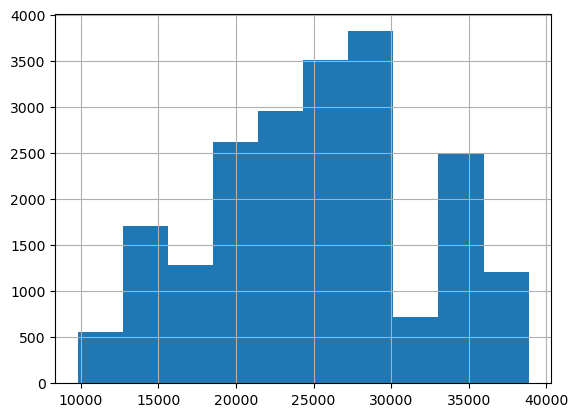

In [21]:
crimes["pontos"].hist()

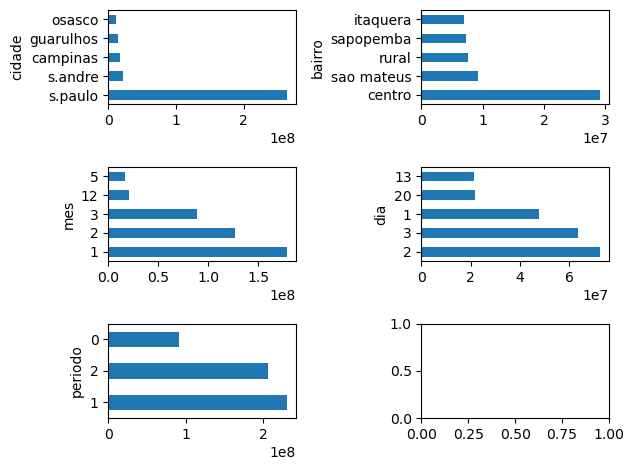

In [22]:
fig, axs = plt.subplots(3, 2)
to_plot = ["cidade", "bairro", "mes", "dia", "periodo"]
for t, ax in zip(to_plot, axs.ravel()):
    crimes.groupby(t)["pontos"].sum().sort_values(ascending=False).head().plot(kind="barh", ax=ax)
plt.tight_layout()

In [23]:
print(f"Total {crimes.shape[0]}\n")
print(crimes.isna().sum())
print()
print(crimes.isna().mean())

Total 20891

cidade          30
bairro          64
logradouro    1414
estacao          0
hora             0
mes              0
dia              0
periodo          0
pontos           0
dtype: int64

cidade        0.001436
bairro        0.003064
logradouro    0.067685
estacao       0.000000
hora          0.000000
mes           0.000000
dia           0.000000
periodo       0.000000
pontos        0.000000
dtype: float64


In [24]:
crimes.dropna(inplace=True)

In [25]:
crimes.to_csv("furtos_scored.csv", index=False)